# Collaborative Filtering

To implement collaborative filtering, we have these steps:

1. Create the user-item matrix

2. Calculate the similarity matrix
3. Calculate the predicted ratings
4. Evaluate the model


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import tqdm

In [37]:
data = pd.read_csv('data/collaborative_filtering.csv')
data.head()

,UserId,BookId,Rating
0,A281NPSIMI1C2R,2,5.0
1,A2TAPL67U2A5HM,2,5.0
2,AT9YSY20RJUDX,2,4.0
3,A2KBHSK5BS35BH,3,1.0
4,A2WZON0QPX7C9X,3,5.0


In [38]:
# train test split
train, test = train_test_split(data, test_size=0.1, random_state=42)

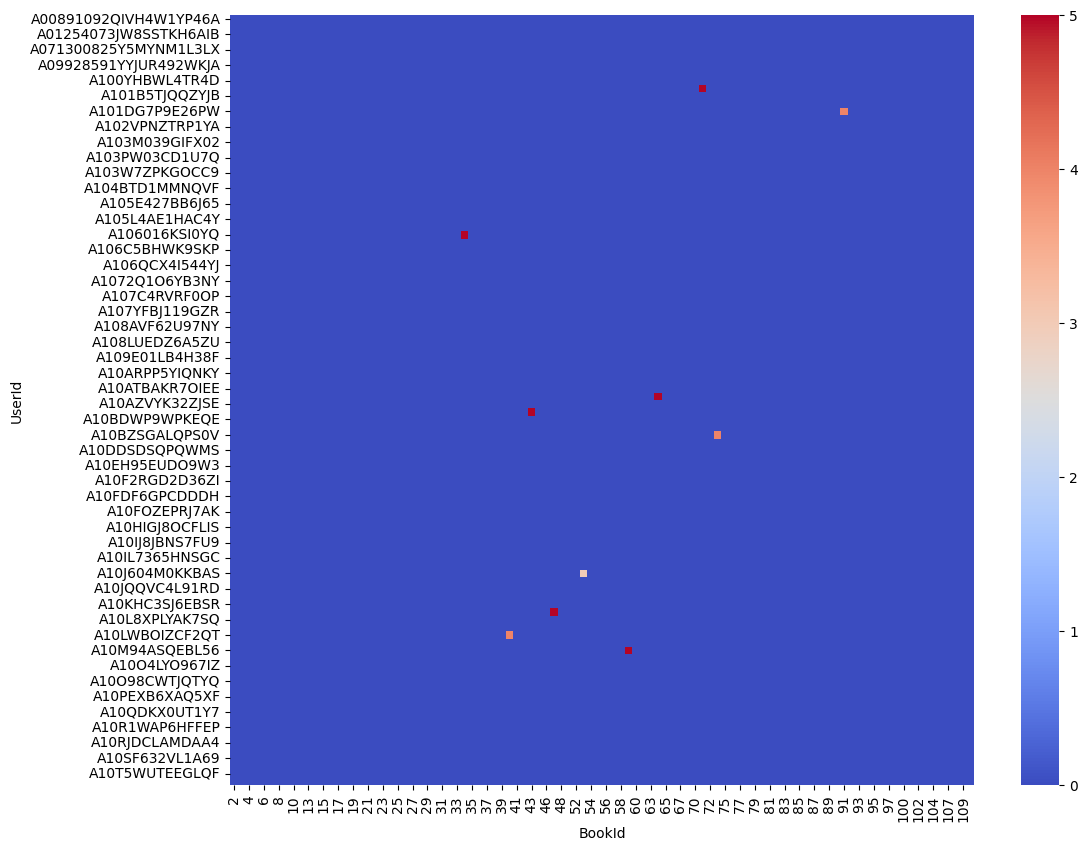

In [39]:
# user-item interaction matrix
interaction_matrix = train.pivot_table(index = 'UserId', columns = 'BookId', values = 'Rating', fill_value=0)
train_matrix = csr_matrix(interaction_matrix)

# Visuallize the user-item interaction matrix
# only show the first 100 rows and columns for better visualization
inter = interaction_matrix.iloc[:100,:100]
plt.figure(figsize=(12,10))
sns.heatmap(inter, annot=False, cmap='coolwarm')
plt.show()

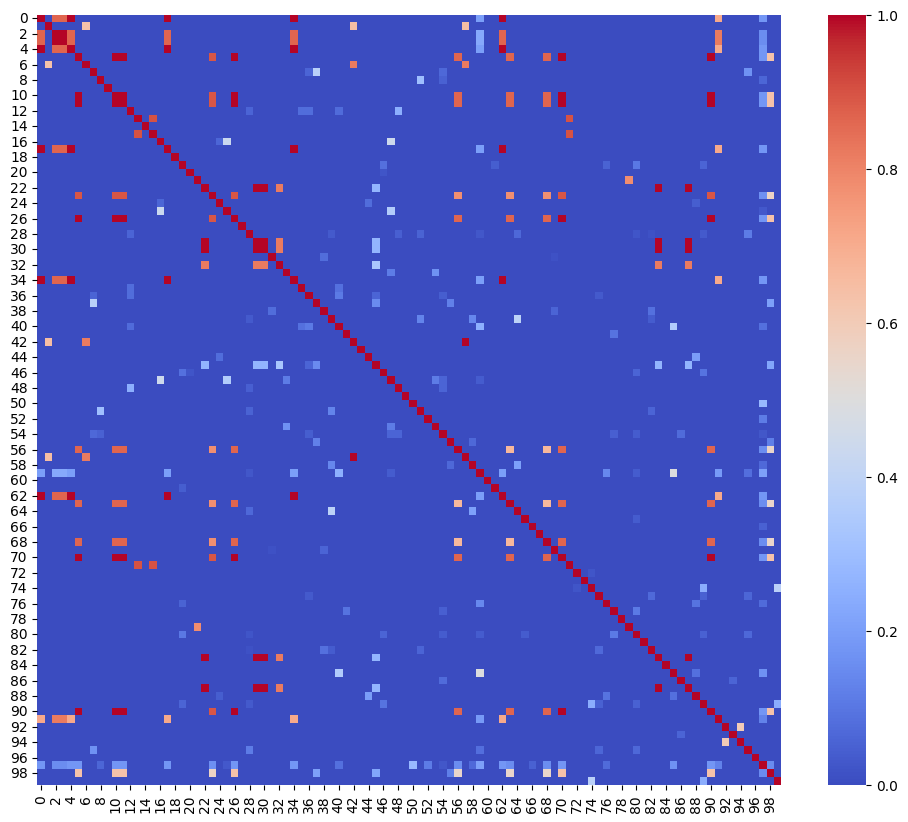

In [40]:
# User Similarity by cosine similarity
user_similarity = cosine_similarity(interaction_matrix)

# Visuallize the user similarity matrix
# only show the first 100 rows and columns for better visualization
usr = user_similarity[:100, :100]
plt.figure(figsize=(12,10))
sns.heatmap(usr, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# test matrix
test_interaction_matrix = test.pivot_table(index='UserId', columns='BookId', values='Rating', fill_value=0)

test_matrix = csr_matrix(test_interaction_matrix)

print(f"Train matrix: {train_matrix.shape}")
print(f"Test matrix: {test_matrix.shape}")

def train(k: int) -> NearestNeighbors:
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='cosine')
    knn.fit(train_matrix)  # train_matrix is a csr_matrix
    return knn

# predict all the models at the same time
def predict(models, n: int):
    true_ratings, predicted_ratings = [], [[] for _ in range(n)]
    
    # Extract non-zero elements of the test matrix
    non_zero_indices = test_matrix.nonzero()  # 返回所有非零元素的行列索引
    users = non_zero_indices[0]  # 用户索引
    items = non_zero_indices[1]  # 产品索引
    
    # Predict ratings for each nonzero user-item pair
    for idx in tqdm.tqdm(range(len(users)), desc="Predicting ratings", ncols=100):
        user = users[idx]
        item = items[idx]
        true_ratings.append(test_matrix[user, item])

        for i, knn in enumerate(models):
            ratings = []
            # Find k nearest neighbors and their ratings
            distances, indices = knn.kneighbors(train_matrix[user, :].reshape(1, -1))
            neighbors = indices[0]  # Indices of nearest neighbors
            neighbor_ratings = train_matrix[neighbors, item].toarray().flatten()  # Neighbors' ratings

            # Filter out invalid ratings
            valid_ratings = neighbor_ratings[neighbor_ratings > 0]
            neighbor_distances = distances[0][:len(valid_ratings)]  # Only valid neighbors

            if len(valid_ratings) > 0:
                # Calculate weighted average of valid neighbors' ratings
                weights = 1 - neighbor_distances  # Inverse distance weighting
                predicted_rating = np.dot(valid_ratings, weights) / np.sum(weights)
            else:
                # If there are no valid neighbors, predict the average rating of the user
                user_ratings = train_matrix[user].toarray().flatten()
                predicted_rating = user_ratings[user_ratings > 0].mean() if user_ratings[user_ratings > 0].size > 0 else 0

            predicted_ratings[i].append(predicted_rating)

    # Calculate loss for each model
    loss_list = []
    for i in range(n):
        loss = mean_squared_error(true_ratings, predicted_ratings[i])
        loss_list.append(loss)
    
    return loss_list, predicted_ratings, true_ratings


# train models with different k
models = []
for k in range(1, 11):
    models.append(train(k))

# predict all the models at the same time
loss_list, predicted_ratings, true_ratings = predict(models, len(models))

# plot loss vs k
k_list = np.arange(1, 11)
plt.plot(k_list, loss_list)
plt.xlabel('k')
plt.ylabel('loss (RMSE)')
plt.show()


Train matrix: (16794, 13430)
Test matrix: (13499, 8182)


Predicting ratings:  11%|████▏                                 | 4150/37559 [03:08<25:22, 21.95it/s]

In [64]:
# Precision@k and Recall@k 
# Helper functions for metrics
def precision_at_k(y_true, y_pred, k):
    """Calculate Precision@K for all users and return the average."""
    precisions = []
    for true_ratings, pred_ratings in zip(y_true, y_pred):
        # Sort predictions and true ratings by predicted scores
        pred_top_k_indices = np.argsort(pred_ratings)[-k:][::-1]  # Top-k predictions
        true_top_k_indices = np.argsort(true_ratings)[-k:][::-1]  # Top-k true ratings
        
        hits = len(set(pred_top_k_indices) & set(true_top_k_indices))
        precisions.append(hits / k)
    return np.mean(precisions)

def recall_at_k(y_true, y_pred, k):
    """Calculate Recall@K for all users and return the average."""
    recalls = []
    for true_ratings, pred_ratings in zip(y_true, y_pred):
        pred_top_k_indices = np.argsort(pred_ratings)[-k:][::-1]  # Top-k predictions
        true_top_k_indices = np.argsort(true_ratings)[-k:][::-1]  # Top-k true ratings
        
        hits = len(set(pred_top_k_indices) & set(true_top_k_indices))
        total_relevant = len(true_top_k_indices)  # Count relevant items
        recalls.append(hits / total_relevant if total_relevant > 0 else 0)
    return np.mean(recalls)

# Evaluate Precision@K and Recall@K for each k
k_values = [1, 3, 5, 10]  # Evaluate at these k-values
for k in k_values:
	print(f"\nMetrics for Top-{k}:")
	for i, knn in enumerate(models):
		precision = precision_at_k(true_ratings, predicted_ratings[i], k)
		recall = recall_at_k(true_ratings, predicted_ratings[i], k)
		print(f"Model (k={i+1}): Precision@{k} = {precision:.4f}, Recall@{k} = {recall:.4f}")



Metrics for Top-1:
Model (k=1): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=2): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=3): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=4): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=5): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=6): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=7): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=8): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=9): Precision@1 = 1.0000, Recall@1 = 1.0000
Model (k=10): Precision@1 = 1.0000, Recall@1 = 1.0000

Metrics for Top-3:
Model (k=1): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=2): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=3): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=4): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=5): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=6): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=7): Precision@3 = 0.3333, Recall@3 = 1.0000
Model (k=8): Precision@3 = 0.3333, Recall@3 = 1.0000
Model